In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## In order to use Yolo, we need to perform several pre-processing steps. 

1. Given the training csv, we will need to conevrt the labels for each box from COCO format to yolo format. 

2. Create a .txt file with all annotations for each image. One line per box and a class identifier

3. Create a blank .txt for the images without boxes.



In [2]:
from ast import literal_eval
import cv2
import matplotlib.pyplot as plt


train_df = pd.read_csv("../input/global-wheat-detection/train.csv")

In [3]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


* The bounding box format as given is [xmin, ymin, widht, height] in pixels. For yolov4, we have to convert these labels into Yolo format. Below is how to do so. 

In [4]:
def convert(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def convert_to_yolo_label(coco_format_box, w = 1024, h = 1024):
    bbox = literal_eval(coco_format_box)
    xmin = bbox[0]
    xmax = bbox[0] + bbox[2]
    ymin = bbox[1]
    ymax = bbox[1] + bbox[3]
    b = (float(xmin), float(xmax), float(ymin), float(ymax))
    yolo_box = convert((w, h), b)
    if np.max(yolo_box) > 1 or np.min(yolo_box) < 0: # Take this opportunity to check that conversion works
        print("BOX HAS AN ISSUE")
    return yolo_box



In [5]:
%%time
train_df['yolo_box'] = train_df.bbox.apply(convert_to_yolo_label)

CPU times: user 7.4 s, sys: 61.7 ms, total: 7.46 s
Wall time: 7.46 s


### Now we have a column in our train data frame with the yolo format

In [6]:
train_df.head()

,image_id,width,height,bbox,source,yolo_box
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,"[0.841796875, 0.234375, 0.0546875, 0.03515625]"
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,"[0.2841796875, 0.5634765625, 0.126953125, 0.05..."
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,"[0.404296875, 0.5703125, 0.072265625, 0.15625]"
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,"[0.86767578125, 0.14501953125, 0.1064453125, 0..."
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,"[0.0859375, 0.19775390625, 0.12109375, 0.11425..."


#### As a sanity check, lets convert back to Pascal format and see if we get the right answer:

Using the first line of the dataframe, we see we get a correct converion back to Pascal (and then we cna do quick math to confirm in COCO format)

In [7]:
def convertYoloToPascal(size, coord):
    x2 = int(((2*size[0]*float(coord[0]))+(size[0]*float(coord[2])))/2)
    x1 = int(((2*size[0]*float(coord[0]))-(size[0]*float(coord[2])))/2)

    y2 = int(((2*size[1]*float(coord[1]))+(size[1]*float(coord[3])))/2)
    y1 = int(((2*size[1]*float(coord[1]))-(size[1]*float(coord[3])))/2)
    return (x1,y1,x2,y2)

convertYoloToPascal((1024, 1024), [0.841796875, 0.234375, 0.0546875, 0.03515625])

(834, 222, 890, 258)

#### Another spot check we can do is check a bounding box on the image:

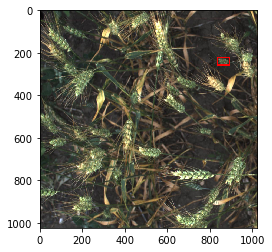

In [8]:
## Check that we can visualize boxes as Coco format:
fr = cv2.imread("../input/global-wheat-detection/train/b6ab77fd7.jpg")
frame_rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
frame_rgb = cv2.rectangle(frame_rgb, (834, 222), (834+56, 222+36), (255, 0, 0), 5)
plt.imshow(frame_rgb)

### Now that conversion looks good, lets write the label files for images with boxes (positives) :

Make a folder where the data will be saved to. For some version of YOLO, all the training iamges and label files are in the same directory. So we can create a directory with all the text files with the lables in the same place. 

In [9]:
print("We have {} unique images with boxes.".format(len(train_df.image_id.unique())))
unique_img_ids = train_df.image_id.unique()

We have 3373 unique images with boxes.


In [10]:
if not os.path.exists("wheat_yolo_train_data"):
    os.makedirs("wheat_yolo_train_data")

In [11]:
folder_location = "wheat_yolo_train_data"
#change  unique_img_ids[:2] to unique_img_ids to iterate through all images
for img_id in unique_img_ids[:2]: # loop through all unique image ids. Remove the slice to do all images
    print(img_id)
    filt_df = train_df.query("image_id == @img_id") # filter the df to a specific id
    #print(filt_df.shape[0])
    all_boxes = filt_df.yolo_box.values
    file_name = "{}/{}.txt".format(folder_location,img_id) # specify the name of the folder and get a file name

    s = "0 %s %s %s %s \n" # the first number is the identifier of the class. If you are doing multi-class, make sure to change that
    with open(file_name, 'a') as file: # append lines to file
        for i in all_boxes:
            new_line = (s % tuple(i))
            file.write(new_line)  


b6ab77fd7
b53afdf5c


In [12]:
!ls wheat_yolo_train_data/

b53afdf5c.txt  b6ab77fd7.txt


In [13]:
!head wheat_yolo_train_data/b53afdf5c.txt

0 0.982421875 0.8095703125 0.03515625 0.09375 
0 0.357421875 0.88916015625 0.068359375 0.0927734375 
0 0.07763671875 0.2431640625 0.0634765625 0.044921875 
0 0.71875 0.9755859375 0.10546875 0.048828125 
0 0.1376953125 0.982421875 0.15234375 0.03515625 
0 0.82861328125 0.91748046875 0.0478515625 0.0751953125 
0 0.83984375 0.4384765625 0.087890625 0.0703125 
0 0.541015625 0.189453125 0.16796875 0.064453125 
0 0.904296875 0.560546875 0.07421875 0.072265625 
0 0.0546875 0.11962890625 0.103515625 0.0673828125 


#### We need to also make labels for the training images that do not have bounding boxes in them.

* This should be a lot easier since we just need an empty file with the name of the image

In [14]:
import glob
all_imgs = glob.glob("../input/global-wheat-detection/train/*.jpg")
all_imgs = [i.split("/")[-1].replace(".jpg", "") for i in all_imgs]
positive_imgs = train_df.image_id.unique()

In [15]:
negative_images = set(all_imgs) - set(positive_imgs)
print(len(all_imgs), len(positive_imgs))

3422 3373


In [16]:
len(negative_images)

49

In [17]:
for i in list(negative_images)[:2]:
    file_name = "wheat_yolo_train_data/{}.txt".format(i)
    print(file_name)
    with open(file_name, 'w') as fp: 
        pass

wheat_yolo_train_data/45fddc611.txt
wheat_yolo_train_data/a3ce975cd.txt


In [18]:
!cat wheat_yolo_train_data/91d4e3750.txt

cat: wheat_yolo_train_data/91d4e3750.txt: No such file or directory


#### As a last step, move all your training images into the same directory. Makse sure to do this with the test set as well if you want to use this as validation.

Hope this helps